In [1]:
import math
import random

In [2]:
"""
SquareGrid class represents agent's environment
0 - cell is traversable
1 - cell is blocked
"""
class SquareGrid:
    #set width, height and fill the grid with zeroes (fully traversable grid)
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.cells = [[0 for _ in range(width)] for _ in range(height)]
    
    #everything else except "#" is considered not to be an obstacle 
    def get_map(self, input_map):
        for i in range(self.height):
            for j in range(self.width):
                if input_map[i * self.width + j] == '#':
                    self.cells[i][j] = 1
    
    #out of bounds check
    def in_bounds(self, i, j):
        return 0 <= j < self.width and 0 <= i < self.height
    
    #blocked cell check
    def traversable(self, i, j):
        if( self.in_bounds(i, j)):
            return not self.cells[i][j]
        else:
            return False
    
    #printing the grid
    def print(self):
        for c in self.cells:
            print(*c)
    
    
    def neighbors(self, i, j, diagonal=False, cutcorners=False, squeeze=False):
        neighbors = []
        for m in [i-1, i, i+1]:
            for n in [j-1, j, j+1]:
                if not self.traversable(m, n) or (i == m and j == n):
                    continue
                if m!=i and j!=n:
                    if  not diagonal:
                        continue
                    if not cutcorners and (not self.traversable(m, j) or not self.traversable(i, n)):
                        continue
                    if not squeeze and not self.traversable(m, j) and not self.traversable(i, n):
                        continue
                neighbors.append((m, n))
        return neighbors

In [3]:
class Node:
    """
    Node class represents a search node
    i, j: coordinates of corresponding grid element
    g: g-value of the node
    h: h-value of the node
    F: f-value of the node
    parent: pointer to the parent-node 
    """
    def __init__(self, i, j, g=math.inf, h=math.inf, F=-1, parent=None):
        self.i = i
        self.j = j
        self.g = g
        if F==-1:
            self.F = self.g + h
        else:
            self.F = F        
        self.parent = parent

#### OPEN list

OPEN is a fringe of the search-space, i.e. it consists of the nodes that have already been generated but not yet expanded.

We should be able to:
i) insert newly generated node to OPEN in case no node with the same (i, j) already resides in OPEN;
ii) update node in case shorter path to the corresponding grid cell is found (update alters g-val, f-val and backpointer, but, obviously, not i, j and h-val);
iii) find the best node, i.e. the node with the lowest f-value.

Let's start withis a very primitive, straight-forward, non-efficent way to implement OPEN list.

In [4]:
class OpenListBasic:
    def __init__(self):
        self.elements = []
    
    #empty should infrom whether the OPEN is exhausted or not (in case it is - the search main loop should be interrupted)
    def empty(self):
        return len(self.elements) == 0
    
    #get is the method that finds the best node (the one with the lowest  f-value),removes it from OPEN and returns it
    def get(self):
        return self.elements.pop(0)
    
    def __add__(self, item):
        if self.empty():
            self.elements.append(item)
            return

        if item.F < self.elements[0].F:
            self.elements.insert(0, item)
            return

        for i in range(1, len(self.elements)):
            if self.elements[i - 1].F <= item.F < self.elements[i].F:
                self.elements.insert(i, item)
                return
        self.elements.append(item)
        return
    
    def put(self, item):
        for it in range(len(self.elements)):
            if self.elements[it].i == item.i and self.elements[it].j == item.j:
                if self.elements[it].F > item.F:
                    self.elements.pop(it)
                    self.__add__(item)
                    return
                else:
                    return
        self.__add__(item)
        return

### Heuristics for grid maps

#### Euclidean distance

Straight line distance is the most intuitive thing to think of as it is the true shortest distance on a plane (thus 100% admissable). Calculation involves taking the square root (so it's a "slow" heuristic). Moreover this distance is not accurate for grid-worlds in many cases as the agent is limited to cardinal and diagonal moves only.

In [5]:
def euclidean_heuristic(a_i, a_j, b_i, b_j):
    dx = abs(a_i - b_i)
    dy = abs(a_j - b_j)
    return math.sqrt(dx * dx + dy * dy)
def euclidean_heuristic_my(a, b):
    dx = abs(a[0] - b[0])
    dy = abs(a[1] - b[1])
    return math.sqrt(dx * dx + dy * dy)

#### Manhattan distance

More accurate heuristic when cardinal moves are allowed. It is not an admissable heuristic if diagonal moves are allowed as well.

In [6]:
def manhattan_heuristic(a_i, a_j, b_i, b_j):
    dx = abs(a_i - b_i)
    dy = abs(a_j - b_j)
    return dx + dy

#### Diagonal distance

More accurate heuristic when diagonal moves are allowed.

In [7]:
def diagonal_heuristic(a_i, a_j, b_i, b_j):
    dx = abs(a_i - b_i)
    dy = abs(a_j - b_j)
    return min(dx, dy)*math.sqrt(2) + abs(dx - dy)

__Let's start with A*__

In [8]:
def calculate_heuristic(a_i, a_j, goal_i, goal_j, heuristic_type='euclidean'):
    if heuristic_type == 'euclidean':
        return euclidean_heuristic(a_i, a_j, goal_i, goal_j)
    if heuristic_type == 'octile':
        return diagonal_heuristic(a_i, a_j, goal_i, goal_j)
    if heuristic_type == 'manhattan':
        return manhattan_heuristic(a_i, a_j, goal_i, goal_j) 
    
def calculate_cost(a_i, a_j, b_i, b_j):
    return math.sqrt(abs(a_i - b_i) * abs(a_i - b_i) + abs(a_j - b_j) * abs(a_j - b_j))


def search(grid, start_i, start_j, goal_i, goal_j,
           heuristic_type='euclidean',
           heuristic_weight=1,
           diagonal=False, 
           cutcorners=False, 
           squeeze=False):
    
    OPEN = OpenListBasic()
    start_node = Node(start_i, start_j, 0, 
                      heuristic_weight * calculate_heuristic(start_i, start_j, goal_i, goal_j, heuristic_type))
    OPEN.put(start_node)
    CLOSED = dict()
    
    while not OPEN.empty():
        current = OPEN.get() #retrieve the best search node from OPEN
        #print(current.i, ' ', current.j, ' ', current.F) #print out the best current node (f-val should increase over the iterations)
        CLOSED[current.i * grid.width + current.j] = current #put the node to CLOSE
        
        if current.i == goal_i and current.j == goal_j:
            ##print("Path has been found!")
            return current, CLOSED
        
        for (i, j) in grid.neighbors(current.i, current.j, diagonal, cutcorners, squeeze):
            if i * grid.width + j not in CLOSED:
                g_cur = current.g + calculate_cost(current.i, current.j, i, j)
                h_cur = calculate_heuristic(i, j, goal_i, goal_j, heuristic_type)
                f_cur = g_cur + heuristic_weight * h_cur
                new_node = Node(i, j, g_cur, h_cur, f_cur, current)
                OPEN.put(new_node)
                
    #print("Path NOT found")
    return current, CLOSED

In [9]:
def make_path(goal):
    current = goal
    path = []
    while current.parent:
        path.append((current.i, current.j))
        current = current.parent;
    path.append((current.i, current.j))
    return path[::-1]

def print_path(grid, path):#, USED):
    for i in range(grid.height):
        for j in range(grid.width):
            if (i, j) in path:
                print("*", "", end='')
            else:
#                 if (i,j) in USED:
#                     print("+",  "", end='')
#                 else:
                print(grid.cells[i][j], "", end='')
        print("\n", end='')

In [10]:
input_map = '''
. . . # . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . # . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

'''

In [11]:
grid = SquareGrid(30, 15)
grid.get_map(input_map.translate({ ord(c):None for c in ' \n\t\r' }))

In [12]:
start_i=0
start_j=0
goal_i=1
goal_j=7

%time
goal, CLOSED = search(grid, start_i, start_j, goal_i, goal_j, diagonal=True, squeeze=False, cutcorners=True)

Wall time: 0 ns


In [13]:
#some valuable info
print("Path's length (largest g-value in case path NOT found):", goal.g)
print("Number of steps:", len(CLOSED))

Path's length (largest g-value in case path NOT found): 26.48528137423857
Number of steps: 68


In [14]:
path = make_path(goal)
print("Found path:", *path, "\n")

print_path(grid, path)

Found path:(0, 0) (1, 1) (2, 1) (3, 2) (4, 2) (5, 2) (6, 2) (7, 2) (8, 2) (9, 2) (10, 2) (11, 2) (12, 3) (12, 4) (11, 5) (10, 6) (9, 6) (8, 6) (7, 6) (6, 7) (5, 7) (4, 7) (3, 7) (2, 7) (1, 7) 

* 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 
0 * 0 1 0 0 0 * 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 
0 * 0 0 1 0 0 * 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 
0 0 * 1 1 0 0 * 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 
0 0 * 1 1 0 0 * 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 
0 0 * 1 1 0 0 * 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 
0 0 * 1 1 0 0 * 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 
0 0 * 1 1 0 * 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 * 1 1 0 * 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 * 1 1 0 * 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 * 1 1 0 * 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 * 1 1 * 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 * * 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0

__Bigger maps__

To feel the difference between using various heuristics, heuristic weights, data structures used for OPEN/CLOSED a bigger map is needed.

### TODO

1. Look for '!!!TODO!!!' comments and follow them
2. Provide a report (pdf) on your experience on evaluation of A* with different heuristics and heuristics weights on a large map.

Requirments for A* evaluation:
- you should use (e.g. create) your own map +
- map should be unique (no maps repetition across students) +
- map size: 256 x 256 (min.) +
- percent of blocked cells: ~20% (e.g. randomly blocked cells) + 
- number of tasks: 50 (min) - 100 (can be larger)
- task generation strategy: any (but you should be able to describe it in a proper way), e.g. random generation of start-goal pairs
- tasks should be unique (no tasks repetition across students)
- At least TWO tests should be carried out:
-- testing (at least two) different heuristics (e.g. Euclidean vs Diagonal)
-- testing (at least three) different weights (e.g. Diagonal heuristic with w=1.1, 1.5, 3)
-- more tests are welcome
- in each test the following indicators should be measured:
-- number of steps
-- path lengths (common sense check: path lenghts should be the same for test1 and should be different for test 2)
- Evaluation results should be presented as plots and (optionally) tables




In [15]:
min_len = 50
points = 100
size = 256

with open('map.txt', 'r') as file:
    big_map = file.read()
    
b_grid = SquareGrid(size, size) #make sure the dimensions match the drawn map
b_grid.get_map(big_map.translate({ ord(c): None for c in ' \n\t\r' })) #remove all whitespaces, tabs etc. 

#generating points

start=[]
goal=[]
miss = 0
st, gl = (), ()
while True:
    st = (random.randint(0, size - 1),random.randint(0, size - 1))
    gl = (random.randint(0, size - 1),random.randint(0, size - 1))
    if(euclidean_heuristic_my(st, gl) >= min_len and b_grid.traversable(st[0], st[1]) and b_grid.traversable(gl[0], gl[1])):
        start.append(st)
        goal.append(gl)
        if(len(start) == points):
            break



In [16]:
import pandas as pd

#testing func

def test(grid, start, goal, method, weightm, diagonal=True, squeeze=False, cutcorners=True):
    result=dict()
    result["Start"] = []
    result["Goal"]= []
    result["h_func"]= []
    result["Weight"]= []
    result["Lenght"]= []
    result["Steps"]= []

    for i in range(len(start)):
        end, CLOSED = search(grid, start[i][0], start[i][1], goal[i][0], goal[i][1],diagonal=diagonal, squeeze=squeeze, cutcorners=cutcorners,heuristic_type=method,heuristic_weight=weightm)
        if(i%10==0):
            print(r'+')
        path = make_path(end)
        result["Start"].append(start[i])
        result["Goal"].append(goal[i])
        result["h_func"].append(method)
        result["Weight"].append(weightm)
        result["Lenght"].append(end.g)
        result["Steps"].append(len(CLOSED))
    return pd.DataFrame(result)



## Counting

In [44]:
%%time
test_results = test(b_grid, start, goal, 'euclidean',1)
test_results.to_csv("euclid_data.csv")

+


KeyboardInterrupt: 

In [ ]:
%%time
test_results = test(b_grid, start, goal, 'manhattan',1)
test_results.to_csv("manhattan_data.csv")

In [ ]:
%%time
test_results = test(b_grid, start, goal, 'octile',1)
test_results.to_csv("octile_data.csv")

In [ ]:
%%time
test_results = test(b_grid, start, goal, 'euclidean',2)
test_results.to_csv("euclid2_data.csv")

In [ ]:
%%time
test_results = test(b_grid, start, goal, 'euclidean',1.5)
test_results.to_csv("euclid1.5_data.csv")

In [ ]:
%%time
test_results = test(b_grid, start, goal, 'euclidean',1.1)
test_results.to_csv("euclid1.1_data.csv")

In [ ]:
%%time
test_results = test(b_grid, start, goal, 'euclidean',3)
test_results.to_csv("euclid3_data.csv")

In [ ]:
%%time
test_results = test(b_grid, start, goal, 'manhattan',1.1)
test_results.to_csv("manhattan1.1_data.csv")

In [31]:
%%time
test_results = test(b_grid, start, goal, 'manhattan',1.5)
test_results.to_csv("manhattan1.5_data.csv")

+
+
+
+
+
+
+
+
+
+
Wall time: 25.7 s


## Tables

In [17]:
import pandas as pd
data_eucl1 = pd.read_csv("euclid_data.csv")
data_manh1 = pd.read_csv("manhattan_data.csv")
data_oct1 = pd.read_csv("octile_data.csv")
data_eucl1

,Unnamed: 0,Start,Goal,h_func,Weight,Lenght,Steps
0,0,"(88, 123)","(228, 132)",euclidean,1,169.710678,4689
1,1,"(222, 244)","(149, 112)",euclidean,1,162.237590,3834
2,2,"(41, 193)","(179, 118)",euclidean,1,193.752309,7517
3,3,"(244, 131)","(148, 126)",euclidean,1,104.698485,1825
4,4,"(85, 187)","(141, 203)",euclidean,1,86.468037,1073
...,...,...,...,...,...,...,...
95,95,"(134, 54)","(215, 178)",euclidean,1,182.296465,5697
96,96,"(213, 162)","(27, 128)",euclidean,1,340.693434,36600
97,97,"(74, 170)","(24, 242)",euclidean,1,116.225397,3456
98,98,"(252, 208)","(4, 113)",euclidean,1,429.374675,41840


In [18]:
data_manh1

,Unnamed: 0,Start,Goal,h_func,Weight,Lenght,Steps
0,0,"(88, 123)","(228, 132)",manhattan,1,169.710678,2063
1,1,"(222, 244)","(149, 112)",manhattan,1,162.237590,143
2,2,"(41, 193)","(179, 118)",manhattan,1,196.095454,5787
3,3,"(244, 131)","(148, 126)",manhattan,1,104.698485,1266
4,4,"(85, 187)","(141, 203)",manhattan,1,86.468037,988
...,...,...,...,...,...,...,...
95,95,"(134, 54)","(215, 178)",manhattan,1,183.124892,1891
96,96,"(213, 162)","(27, 128)",manhattan,1,340.693434,24914
97,97,"(74, 170)","(24, 242)",manhattan,1,118.225397,2703
98,98,"(252, 208)","(4, 113)",manhattan,1,429.374675,33716


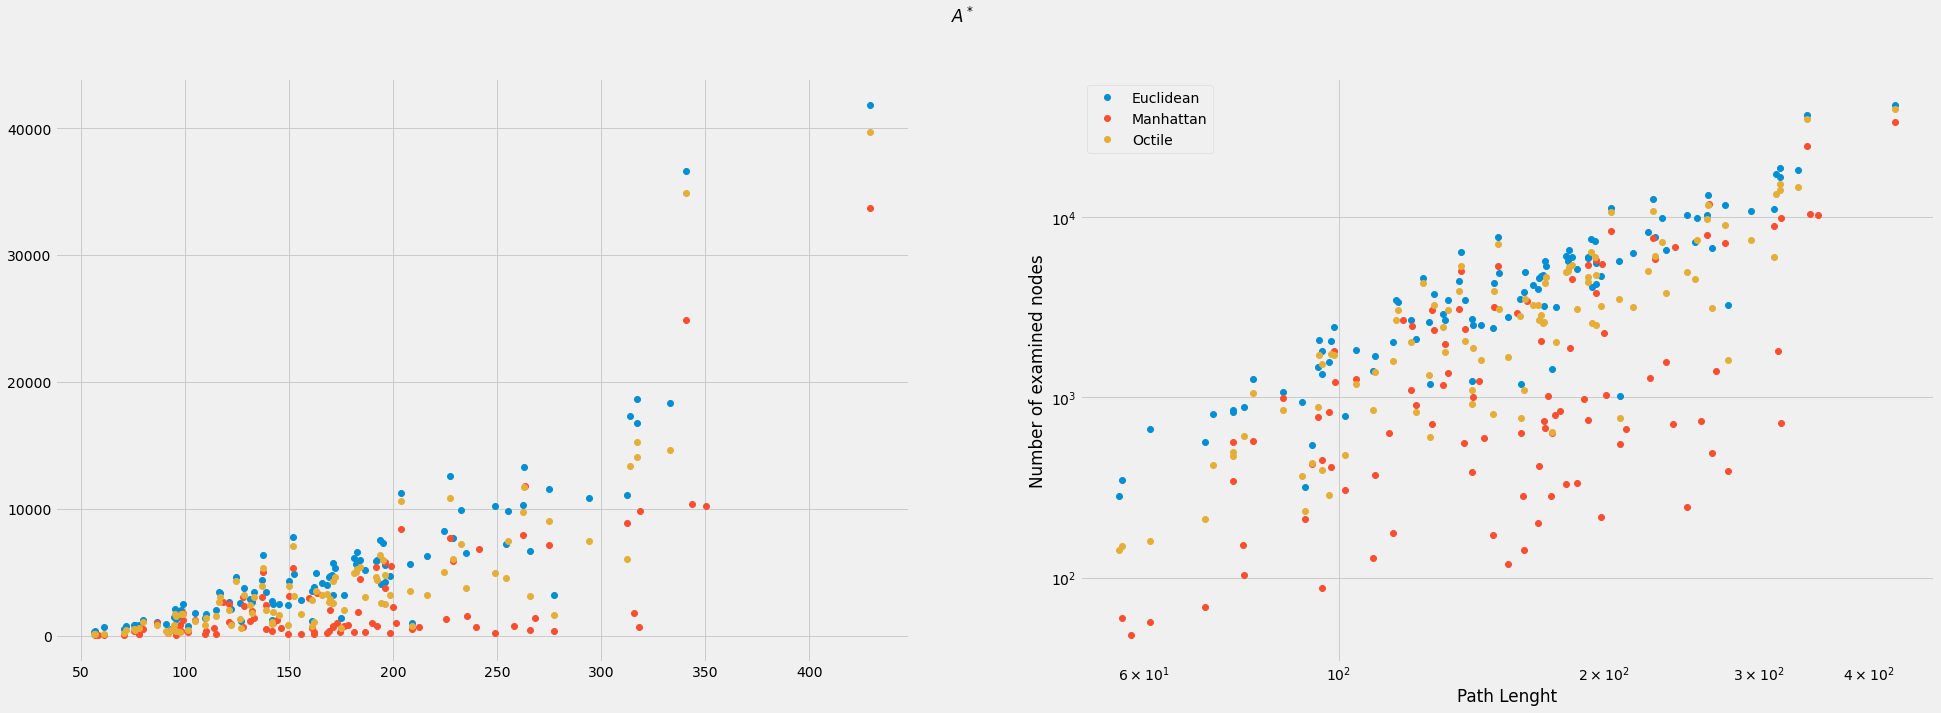

In [19]:
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")

#plt.figure(figsize=(10,300))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
fig.suptitle("$A^*$")
ax1.plot(data_eucl1["Lenght"], data_eucl1["Steps"], "o", label="Euclidean")
ax1.plot(data_manh1["Lenght"], data_manh1["Steps"], "o", label="Manhattan")
ax1.plot(data_oct1["Lenght"], data_oct1["Steps"], "o", label="Octile")
plt.xlabel("Path Lenght")
plt.ylabel("Number of examined nodes")
ax2.plot(data_eucl1["Lenght"], data_eucl1["Steps"], "o", label="Euclidean")
ax2.plot(data_manh1["Lenght"], data_manh1["Steps"], "o", label="Manhattan")
ax2.plot(data_oct1["Lenght"], data_oct1["Steps"], "o", label="Octile")
plt.semilogy()
plt.semilogx()

plt.legend()
plt.show()

## Counting

Wall time: 0 ns
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+


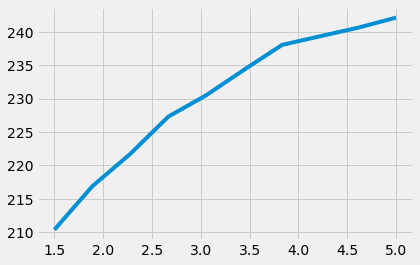

In [22]:
%time
import numpy as np
data_eucl11 = pd.read_csv("euclid1.1_data.csv")
data_eucl15 = pd.read_csv("euclid1.5_data.csv")
data_eucl2 = pd.read_csv("euclid2_data.csv")
data_eucl3 = pd.read_csv("euclid3_data.csv")

x = np.linspace(1.5, 5, 10)
y = []
for i in x:
    y.append(test(b_grid, start, goal, 'euclidean',i)["Lenght"].mean())


In [24]:
%%time
x1 = np.linspace(1.5, 5, 10)
y1 = []
for i in x1:
    y1.append(test(b_grid, start, goal, 'manhattan',i)["Lenght"].mean())

+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
Wall time: 4min 20s


## Plot

Text(0, 0.5, 'Average Lenght')

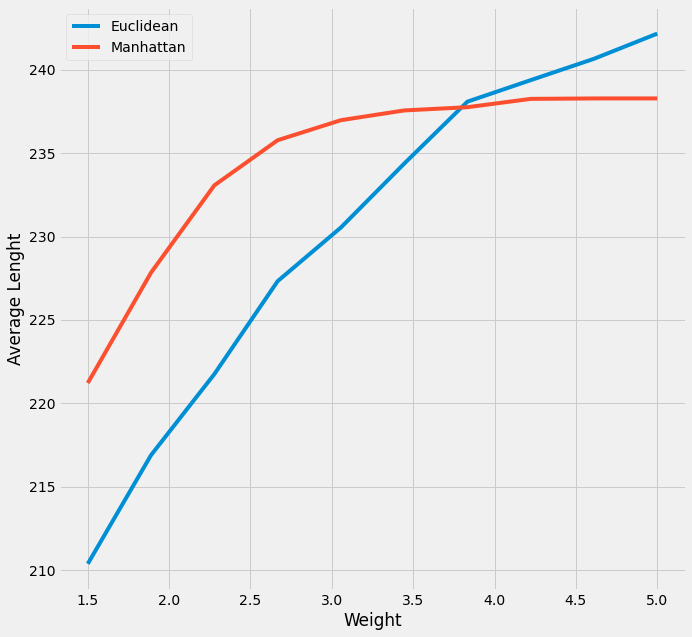

In [26]:
plt.figure(figsize=(10,10))
plt.plot(x, y, label="Euclidean")
plt.plot(x1, y1, label="Manhattan")
plt.legend()
plt.xlabel("Weight")
plt.ylabel("Average Lenght")


## Count

In [27]:
%%time
x = np.linspace(1.5, 5, 10)
ecl_steps = []
for i in x:
    ecl_steps.append(test(b_grid, start, goal, 'euclidean',i)["Steps"].mean())

manh_steps = []
for i in x:
    manh_steps.append(test(b_grid, start, goal, 'manhattan',i)["Steps"].mean())

+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
Wall time: 9min 13s


## Plot

Text(0, 0.5, 'Average Steps')

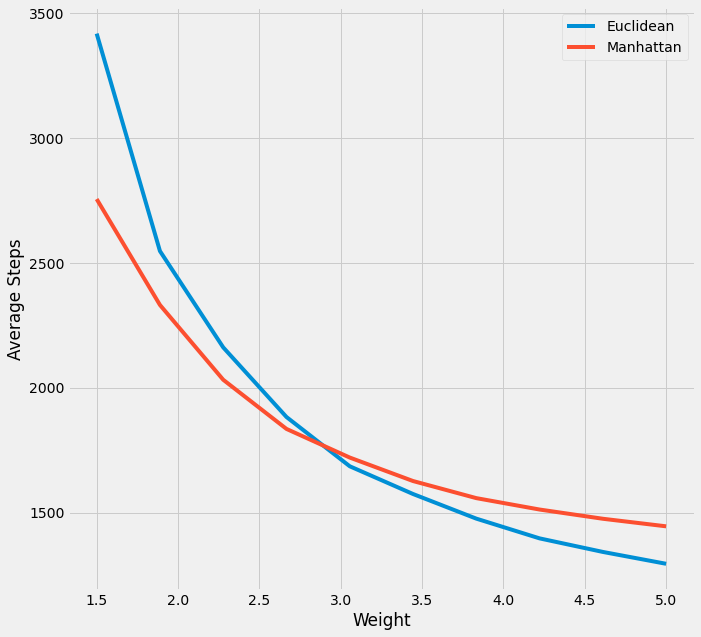

In [29]:
plt.figure(figsize=(10,10))
plt.plot(x, ecl_steps, label="Euclidean")
plt.plot(x, manh_steps, label="Manhattan")
plt.legend()
plt.xlabel("Weight")
plt.ylabel("Average Steps")
